In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x238fc8aa950>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08}

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
max_date = session.query(func.max(func.DATE(measurement.date))).all()

for row in max_date:
    print(row[0])

2017-08-23


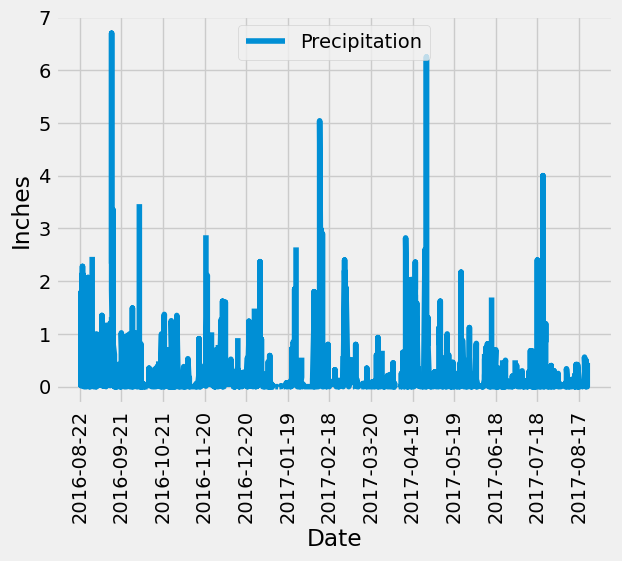

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
max_date = session.query(func.max(measurement.date)).all()

for row in max_date:
    max_date = datetime.strptime(row[0], '%Y-%m-%d').date()
    new_date = datetime.strptime(row[0], '%Y-%m-%d').date() - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
perc_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= new_date).all()

prcp_date = []
prcp_measure = []

for x, y in perc_scores:
    prcp_date.append(datetime.strptime(x, '%Y-%m-%d').date())
    prcp_measure.append(y)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_list = list(zip(prcp_date, prcp_measure))
prcp_df = pd.DataFrame(prcp_list,columns=['prcp_date','prcp_measure'])

# Sort the dataframe by date
prcp_df.sort_values('prcp_date', ascending=False, inplace=True)
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot.line('prcp_date', 'prcp_measure', label='Precipitation')
ax.set_xlabel('Date')
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Inches')
ax.legend(loc='upper center')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp_measure
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(stations.station)).all()
station_count

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_freq = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_count = 0
max_station = ''
for x, y in station_freq:
    if y > max_count:
        max_count = y
        max_station = x

max_station_stat = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == max_station).all()
max_station_stat


[(54.0, 85.0, 71.66378066378067)]

station: USC00519281, date range: 2016-08-23 to 2017-08-23
352


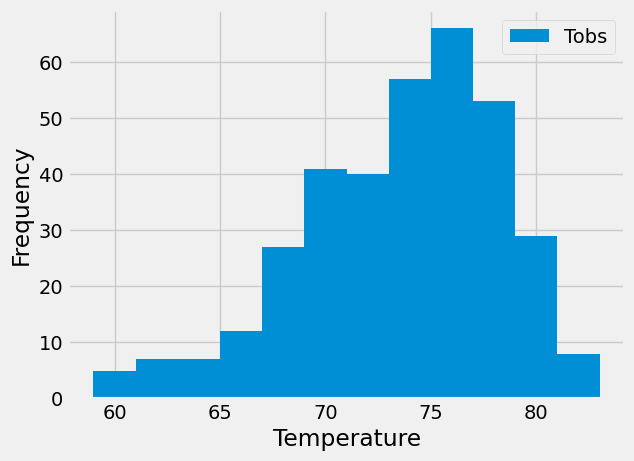

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_date = session.query(func.max(measurement.date)).all()

for row in max_date:
    max_date = datetime.strptime(row[0], '%Y-%m-%d').date()
    new_date = datetime.strptime(row[0], '%Y-%m-%d').date() - timedelta(days=365)

print(f"station: {max_station}, date range: {new_date} to {max_date}")

# Perform a query to retrieve the data and precipitation scores
tobs_scores = session.query(measurement.tobs).filter(measurement.date >= new_date).filter(measurement.station == max_station).all()

tobs_temp = []

for x in tobs_scores:
    tobs_temp.append(float(x[0]))

tobs_list = list(tobs_temp)
print(len(tobs_list))

# # Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(tobs_scores,columns=['Temperature'])


# # Use Pandas Plotting with Matplotlib to plot the data
plt.hist(tobs_df,bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['Tobs'])
plt.show() 

# Close Session

In [17]:
# Close Session
session.close()